# RNNs in PyTorch
## Name Generation

In [1]:
# Data preprocessing
from io import open
import glob
import os
import unicodedata
import string
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Russian', 'Chinese', 'Polish', 'Korean', 'Greek', 'Arabic', 'Japanese', 'French', 'Portuguese', 'Vietnamese', 'Italian', 'English', 'German', 'Dutch', 'Spanish', 'Scottish', 'Irish', 'Czech']
O'Neal


## Model Definitions

In [2]:
class RNNSimple(nn.Module):
    def __init__(self, hidden_size, output_size, activation=nn.ReLU()):
        super().__init__()
        self.hidden_size = hidden_size
        self.h2h = nn.Linear(hidden_size,hidden_size)
        self.i2h = nn.LazyLinear(hidden_size)
        self.act = activation
        self.h2o = nn.LazyLinear(output_size)
        # self.smx = nn.LogSoftmax(dim=1)

    def forward(self, X, hidden):
        # print('Hidden: ',hidden.shape)
        i2h = self.i2h(X)
        h2h = self.h2h(hidden)
        in_combined = h2h+i2h
        # print('Combined: ',in_combined.shape)
        hidden = self.act(in_combined)
        # print('New Hidden: ',hidden.shape)
        out = self.h2o(hidden)
        # out = self.smx(out)
        return out, hidden

    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

class RNNComplex(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        # output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Training

In [3]:
# Helper functions
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [4]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    optimizer.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        # input_combined = torch.cat((category_tensor,input_line_tensor[i]),1)
        output, hidden = model(category_tensor,input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [5]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [6]:
criterion = nn.CrossEntropyLoss()
model = RNNComplex(n_letters,128,n_letters)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 26s (5000 5%) 2.1501
0m 51s (10000 10%) 1.6855
1m 16s (15000 15%) 4.1814
1m 46s (20000 20%) 2.7116
2m 12s (25000 25%) 2.0135
2m 38s (30000 30%) 2.9913
3m 2s (35000 35%) 1.6481
3m 28s (40000 40%) 2.6968
3m 54s (45000 45%) 2.3784
4m 21s (50000 50%) 3.2057
4m 54s (55000 55%) 2.6421
5m 47s (60000 60%) 2.1181
6m 34s (65000 65%) 2.7696
6m 58s (70000 70%) 2.6198
7m 25s (75000 75%) 2.5004
7m 48s (80000 80%) 2.5259
8m 12s (85000 85%) 2.6045
8m 36s (90000 90%) 2.7736
8m 59s (95000 95%) 1.4696
9m 23s (100000 100%) 2.1402


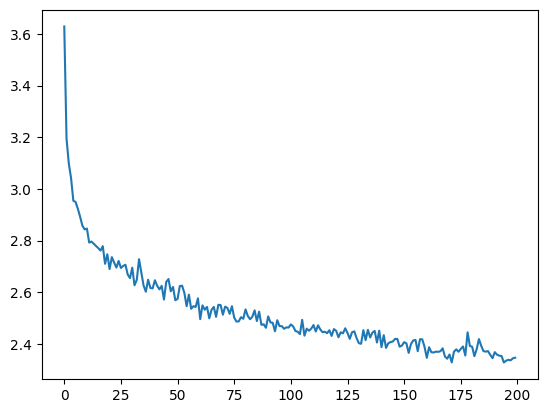

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [9]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_length):
            # input_combined = torch.cat((category_tensor,input[0]),1)
            output, hidden = model(category_tensor,input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rongon
Uangan
Sangano
Geren
Eeren
Rong
Sana
Perana
Arana
Chan
Han
Ian
